DATA LOADING AND SHOWING IMAGE

Loading MNIST dataset...
MNIST dataset loaded.


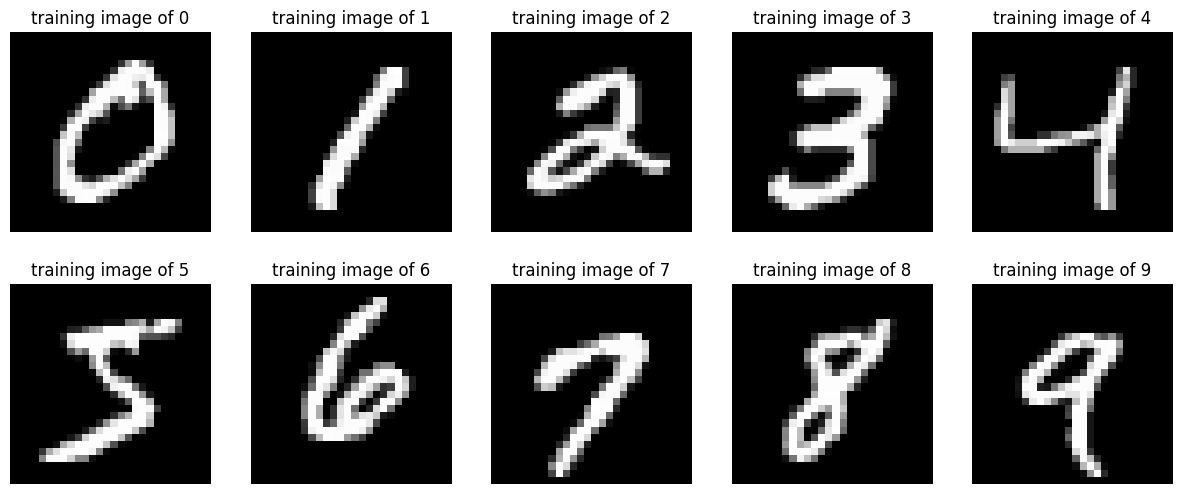

In [6]:
import os
import struct
from array import array
import numpy as np
import matplotlib.pyplot as plt
import random

class MnistDataloader:
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch, expected 2049, got {magic}')
            labels = np.frombuffer(file.read(), dtype=np.uint8)

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch, expected 2051, got {magic}')
            images = np.frombuffer(file.read(), dtype=np.uint8).reshape(size, rows, cols)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

# Set file paths relative to the current working directory
working_dir = os.getcwd()
training_images_filepath = os.path.join(working_dir, 'train-images.idx3-ubyte')
training_labels_filepath = os.path.join(working_dir, 'train-labels.idx1-ubyte')
test_images_filepath = os.path.join(working_dir, 't10k-images.idx3-ubyte')
test_labels_filepath = os.path.join(working_dir, 't10k-labels.idx1-ubyte')

# Load MNIST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')

# Show example images
def show_images(images, title_texts, cols=5):
    rows = len(images) // cols + (len(images) % cols != 0)
    plt.figure(figsize=(15, 3 * rows))
    for i, (image, title) in enumerate(zip(images, title_texts)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title, fontsize=12)
        plt.axis('off')
    plt.show()

# Function to get one image per class
def get_one_image_per_class(images, labels):
    class_dict = {i: None for i in range(10)}  # Dictionary to store one image per class
    filled_classes = set()

    for image, label in zip(images, labels):
        if class_dict[label] is None:
            class_dict[label] = image
            filled_classes.add(label)
        if len(filled_classes) == 10:
            break

    return class_dict

# Get one image per class from the training set
class_images_train = get_one_image_per_class(x_train, y_train)
train_images, train_titles = zip(*[(img, f'training image of {i}') for i, img in class_images_train.items()])


# Show images from training set
show_images(train_images, train_titles, cols=5)




TRAINING AND VALIDATION SETS

In [8]:
from sklearn.model_selection import train_test_split

# Split the training data into 80% training and 20% validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Display the sizes of the resulting datasets
print(f'Training set:   {len(x_train)} images')
print(f'Validation set: {len(x_valid)} images')



Training set:   48000 images
Validation set: 12000 images


CNN ARCHITECTURE

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)  # input channels = 1 (grayscale), output channels = 6, kernel size = 5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)  # input channels = 6, output channels = 12, kernel size = 5x5
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)  # 4x4 image dimension after two poolings, 120 output features
        self.fc2 = nn.Linear(in_features=120, out_features=10)  # final output: 10 classes
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))  # First convolutional layer with ReLU activation
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max pooling with kernel size 2x2 and stride 2
        
        x = F.relu(self.conv2(x))  # Second convolutional layer with ReLU activation
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max pooling with kernel size 2x2 and stride 2
        
        # Flatten the output for fully connected layers
        x = x.view(-1, self.num_flat_features(x))
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation in the last layer because it is handled by CrossEntropyLoss
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Initialize the CNN
model = SimpleCNN()
print(model)  # Print the model architecture


ModuleNotFoundError: No module named 'torch'

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Add this line to import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms

# Set random seed for reproducibility
torch.manual_seed(42)

# Assuming x_train, x_valid, y_train, y_valid are already defined
# and represent the data split using train_test_split from sklearn

# Convert data to PyTorch Tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_valid_tensor = torch.tensor(x_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create TensorDataset and DataLoader for validation
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

# Define batch size and other hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 10


In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN model
model = SimpleCNN()


In [18]:
# Define loss function (CrossEntropyLoss) and optimizer (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [19]:
train_losses = []
valid_losses = []

best_valid_loss = float('inf')
best_model_state_dict = None

for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate training loss
        total_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target)
            total_valid_loss += loss.item()
    
    # Calculate average validation loss for the epoch
    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')
    
    # Save the model with the best validation loss
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state_dict = model.state_dict()

# Load the best model state dict
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[1, 64, 28, 28] to have 1 channels, but got 64 channels instead

Epoch [1/10], Train Loss: 0.5554, Valid Loss: 0.1641
Epoch [2/10], Train Loss: 0.1283, Valid Loss: 0.1043
Epoch [3/10], Train Loss: 0.0907, Valid Loss: 0.0905
Epoch [4/10], Train Loss: 0.0727, Valid Loss: 0.0788
Epoch [5/10], Train Loss: 0.0595, Valid Loss: 0.0727
Epoch [6/10], Train Loss: 0.0507, Valid Loss: 0.0850
Epoch [7/10], Train Loss: 0.0434, Valid Loss: 0.0763
Epoch [8/10], Train Loss: 0.0369, Valid Loss: 0.0782
Epoch [9/10], Train Loss: 0.0327, Valid Loss: 0.0746
Epoch [10/10], Train Loss: 0.0288, Valid Loss: 0.0666


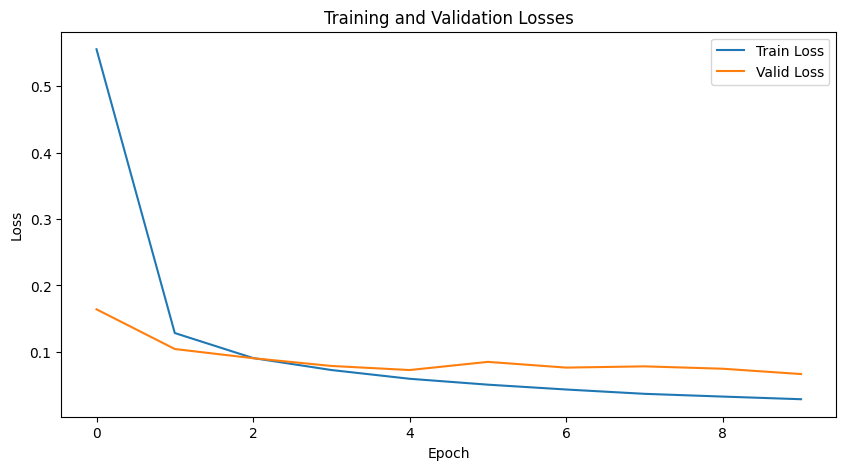

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms

# Set random seed for reproducibility
torch.manual_seed(42)

# Assuming x_train, x_valid, y_train, y_valid are already defined
# and represent the data split using train_test_split from sklearn

# Convert data to PyTorch Tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_valid_tensor = torch.tensor(x_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create TensorDataset and DataLoader for validation
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

# Define batch size and other hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 10

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store losses for plotting
train_losses = []
valid_losses = []

best_valid_loss = float('inf')
best_model_state_dict = None

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))  # Add channel dimension for grayscale images
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data.unsqueeze(1))  # Add channel dimension for grayscale images
            loss = criterion(output, target)
            total_valid_loss += loss.item()
    
    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')
    
    # Save the model with the best validation loss
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state_dict = model.state_dict()

# Load the best model state dict
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')


Test Accuracy: 0.9814


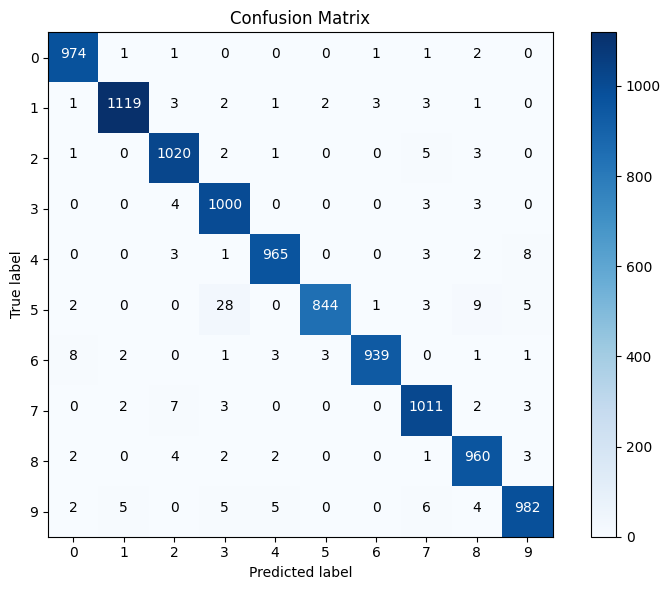

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools  # Import itertools module for iterating over combinations

# Assuming you have already loaded x_train, y_train, x_test, y_test using MnistDataloader
# Define batch size and other hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 10

# Define DataLoader for the test set (using your loaded data)
test_dataset = list(zip(x_test, y_test))  # Create a list of tuples (image, label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize your model (SimpleCNN) and load the best trained weights
model = SimpleCNN()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set model to evaluation mode

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Iterate over the test set and collect predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()  # Convert input images to float type
        outputs = model(images.unsqueeze(1))  # Unsqueeze to add channel dimension (assuming your model expects a single channel)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


Part2